# Momentum and Energy Budgets in NeverWorld2 with Xarray

Neeraja Bhamidipati and Ryan Aberanthey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake

The momentum equation for layer $k$ is given by

\begin{align}
    \frac{\partial \mathbf{u}_k}{\partial t} + \left(\frac{{f} + {\zeta}_k}{h_k} \right) \hat{\mathbf{k}} \times \left( \mathbf{u}_k h_k \right) + \nabla K_k = - \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2} + F_{hor} + F_{vert}
    \; 
    \label{eqn:u} \;,
\end{align}

where $\mathbf{u}_k$ is the horizontal velocity of layer $k$, $h_k$ is the layer thickness, and $\eta_k$ is the height of the upper surface of the layer relative to the reference height. $\zeta_k\hat{\mathbf{k}} \equiv \nabla \times \mathbf{u}_k$ and $K_k = \left(\mathbf{u}_k \cdot \mathbf{u}_k \right)/2$. $F_{hor}$ and $F_{vert}$ are the horizontal and vertical friction terms. In the model, the zonal and meridional components of the second term, $- \left(({f} + {\zeta}_k)/ h_k \right) \hat{\mathbf{k}} \times \left( \mathbf{u}_k h_k \right) - \nabla K_k$, are diagnosed as CAu and CAv. The first term on the RHS, the pressure force accelaration has two components: baroclinic (diagnosed as PFu and PFv) and barotropic (diagnosed as u_BT_accel and v_BT_accel). 

Note that the equation for KE is obtained by multipying the above equation by $\mathbf{u}_k h_k$, and so the terms in the KE budget have a one-to-one correspondence with the terms in the momentum budget. 

## Load OSN Data from Catalog

First we look at the available data.
The data catalog lives at https://github.com/ocean-eddy-cpt/cpt-data/blob/master/catalog.yaml.
For now, this repo is still private, so we have to download the catalog file.
In the future, when we make it public, we will be able to load the catalog directly a github url.

In [2]:
cat = intake.open_catalog('../cpt-data/catalog.yaml')
list(cat)

['neverworld_five_day_averages',
 'neverworld_quarter_degree_snapshots',
 'neverworld_quarter_degree_averages',
 'neverworld_quarter_degree_static',
 'neverworld_quarter_degree_stats',
 'neverworld_eighth_degree_averages',
 'neverworld_eighth_degree_static',
 'neverworld_eighth_degree_stats',
 'neverworld_sixteenth_degree_snapshots',
 'neverworld_sixteenth_degree_averages',
 'neverworld_sixteenth_degree_static',
 'neverworld_sixteenth_degree_stats']

Now we pick an experiment to analyze (the 1/4 degree).
Note that these all use "lazy" loading. The actual data are not downloaded until we need them.

In [3]:
ds_stats = cat['neverworld_quarter_degree_stats'].to_dask()
ds_stats

<xarray.Dataset>
Dimensions:        (Interface: 16, Layer: 15, Time: 6680)
Coordinates:
  * Interface      (Interface) float64 1.022e+03 1.023e+03 ... 1.028e+03
  * Layer          (Layer) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * Time           (Time) timedelta64[ns] 0 days 5 days ... 30500 days
Data variables:
    APE            (Time, Interface) float64 dask.array<chunksize=(6680, 16), meta=np.ndarray>
    En             (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
    H0             (Time, Interface) float64 dask.array<chunksize=(6680, 16), meta=np.ndarray>
    KE             (Time, Layer) float64 dask.array<chunksize=(6680, 15), meta=np.ndarray>
    Mass           (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
    Mass_anom      (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
    Mass_chg       (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
    Mass_lay       (Time, Layer) float64 dask.array<chunksize=(6680, 15), meta=np.ndarray>
    Ntrunc         (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
    max_CFL_lin    (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
    max_CFL_trans  (Time) float64 dask.array<chunksize=(6680,), meta=np.ndarray>
Attributes:
    filename:  ./ocean.stats.nc

In [4]:
ds_snap = cat['neverworld_quarter_degree_snapshots'].to_dask()
ds_snap

<xarray.Dataset>
Dimensions:  (time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zl: 15)
Coordinates:
  * time     (time) object 0084-05-06 00:00:00 ... 0085-09-21 00:00:00
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq       (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    KE       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    h        (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    u        (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v        (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static.nc
    filename:          snapshots_00030005.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             NeverWorld2

In [5]:
ds_avg = cat['neverworld_quarter_degree_averages'].to_dask()
ds_avg

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_horvisc  (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_visc     (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    PE_to_KE    (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    PFu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    PFv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    PV          (time, zl, yq, xq) float32 dask.array<chunksize=(10, 15, 561, 241), meta=np.ndarray>
    Rd1         (time, yh, xh) float32 dask.array<chunksize=(100, 560, 240), meta=np.ndarray>
    Rd_dx       (time, yh, xh) float32 dask.array<chunksize=(100, 560, 240), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    dKE_dt      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    diffu       (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    diffv       (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    du_dt_visc  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    dudt        (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    dv_dt_visc  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    dvdt        (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    e2          (time, zi, yh, xh) float32 dask.array<chunksize=(10, 16, 560, 240), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(100, 2), meta=np.ndarray>
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static

In [6]:
ds_static = cat['neverworld_quarter_degree_static'].to_dask()
ds_static

<xarray.Dataset>
Dimensions:      (time: 1, xh: 240, xq: 241, yh: 560, yq: 561)
Coordinates:
  * time         (time) object 0001-01-01 00:00:00
  * xh           (xh) float64 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * xq           (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh           (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq           (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.5 69.75 70.0
Data variables:
    Coriolis     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    area_t       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    area_u       (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    area_v       (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    depth_ocean  (yh, xh) float32 dask.array<chunksize=(560, 240), meta=np.ndarray>
    dxCu         (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    dxCv         (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    dyCu         (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    dyCv         (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    geolat       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    geolat_c     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    geolat_u     (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    geolat_v     (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
    geolon       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    geolon_c     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    geolon_u     (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    geolon_v     (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
    wet          (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    wet_c        (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    wet_u        (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    wet_v        (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
Attributes:
    filename:   static.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      NeverWorld2

## Assess Equilibration

The X axis on the "statistics" dataset does not get formatted with a proper time unit because the data type is `timedelta[ns]`.
This is different from all the other datasets.
To fix this, we can define a new coordinate to use for plotting.

In [7]:
ds_stats.coords['days'] = ds_stats.Time / 1e9 / (24*60*60)

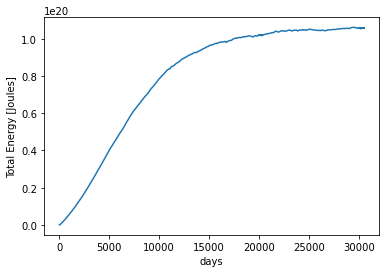

In [8]:
ds_stats.En.plot(x='days')

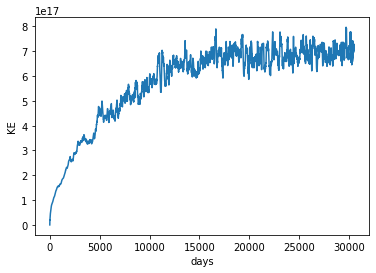

In [9]:
ds_stats.KE.sum(dim='Layer').plot(x='days')

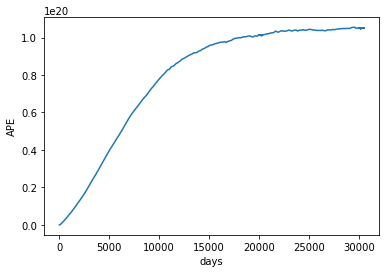

In [10]:
ds_stats.APE.sum(dim='Interface').plot(x='days')

## Momentum budget

Here we evaluate the meridional and zonal components of the momentum equation separately.
We construct the budget "lazily", for all layers and timesteps.

In [11]:
budget_terms_u = ['dudt', 'CAu', 'PFu', 'u_BT_accel', 'diffu', 'du_dt_visc']
# construct a single data array representing all the terms
# adds a new dimension to the dataset called "term"
ds_budget_u = xr.concat([ds_avg[term] for term in budget_terms_u],
                        xr.DataArray(budget_terms_u, dims=['term'], name='term'))
ds_budget_u

<xarray.DataArray 'dudt' (term: 6, time: 100, zl: 15, yh: 560, xq: 241)>
dask.array<concatenate, shape=(6, 100, 15, 560, 241), dtype=float32, chunksize=(1, 10, 15, 560, 241), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
  * term     (term) <U10 'dudt' 'CAu' 'PFu' 'u_BT_accel' 'diffu' 'du_dt_visc'
Attributes:
    cell_methods:   zl:mean yh:mean xq:point time: mean
    interp_method:  none
    long_name:      Zonal Acceleration
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m s-2

Now we actually load some data for plotting.
This takes a little time as the data are transferred over the internet.
We pick the last timestep and the 5th layer.

In [12]:
%time ds_budget_u_to_plot = ds_budget_u.isel(time=-1, zl=4).load()

CPU times: user 1.79 s, sys: 1.82 s, total: 3.61 s
Wall time: 7.08 s


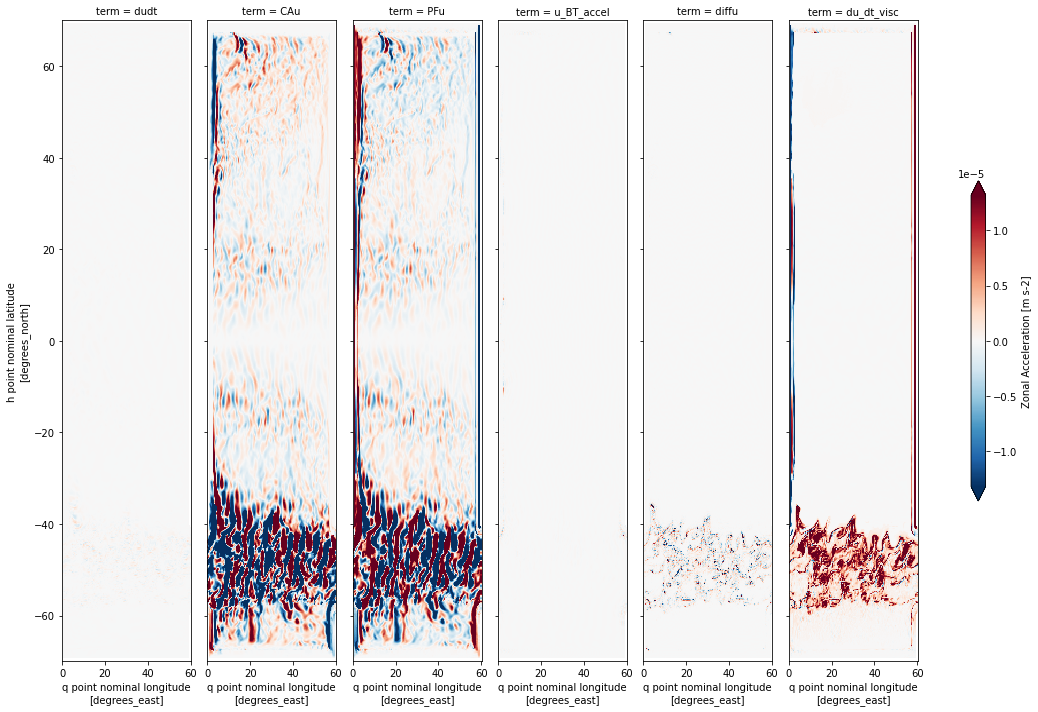

In [13]:
ds_budget_u_to_plot.plot(col='term', figsize=(16, 10), cbar_kwargs={'shrink': 0.5}, robust=True)

### Check budget residual

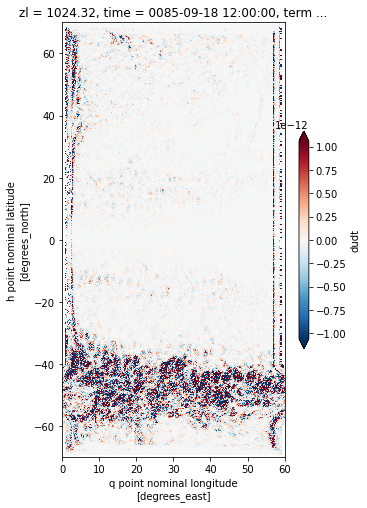

In [14]:
residual_u = ds_budget_u_to_plot.sel(term='dudt') - ds_budget_u_to_plot.drop_sel(term='dudt').sum(dim='term')
residual_u.plot(figsize=(5, 8), robust=True, cbar_kwargs={'shrink': 0.5})

We won't bother with the V budget for now. It's largely the same.

## KE budget

In [15]:
budget_terms_ke = ['dKE_dt', 'KE_CorAdv', 'PE_to_KE', 'KE_BT', 'KE_visc', 'KE_horvisc']
ds_budget_ke = xr.concat([ds_avg[term] for term in budget_terms_ke],
                        xr.DataArray(budget_terms_ke, dims=['term'], name='term'))
ds_budget_ke

<xarray.DataArray 'dKE_dt' (term: 6, time: 100, zl: 15, yh: 560, xh: 240)>
dask.array<concatenate, shape=(6, 100, 15, 560, 240), dtype=float32, chunksize=(1, 10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * term     (term) <U10 'dKE_dt' 'KE_CorAdv' ... 'KE_visc' 'KE_horvisc'
Attributes:
    cell_measures:  area: area_t
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    long_name:      Kinetic Energy Tendency of Layer
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m3 s-3

In [16]:
%time ds_budget_ke_to_plot = ds_budget_ke.isel(time=-1, zl=4).load()

CPU times: user 1.87 s, sys: 1.77 s, total: 3.63 s
Wall time: 6.92 s


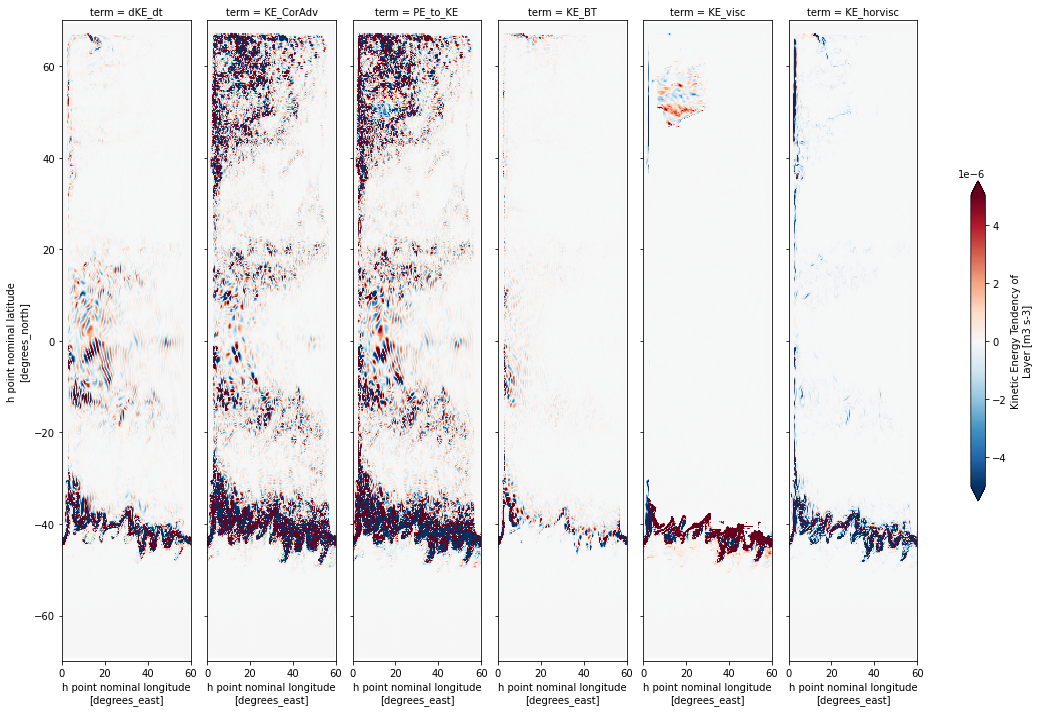

In [17]:
ds_budget_ke_to_plot.plot(col='term', figsize=(16, 10), cbar_kwargs={'shrink': 0.5}, robust=True)

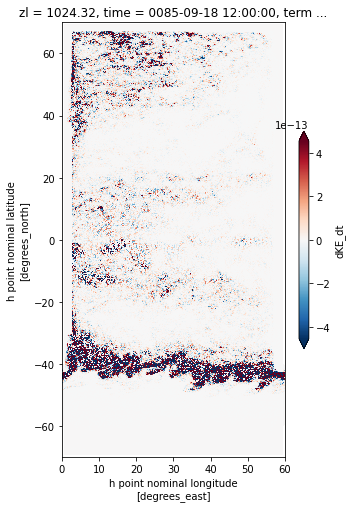

In [18]:
residual_ke = ds_budget_ke_to_plot.sel(term='dKE_dt') - ds_budget_ke_to_plot.drop_sel(term='dKE_dt').sum(dim='term')
residual_ke.plot(figsize=(5, 8), robust=True, cbar_kwargs={'shrink': 0.5})

### Global Mean Kinetic Enegy Budget

Again we do things lazily and only load the data when it's time for plotting.

In [19]:
weights_h = np.cos(np.deg2rad(ds_static.xh))
spatial_mean_ke_budget = ds_budget_ke.weighted(weights_h).mean(dim=['yh', 'xh'])
spatial_mean_ke_budget

<xarray.DataArray (term: 6, time: 100, zl: 15)>
dask.array<truediv, shape=(6, 100, 15), dtype=float64, chunksize=(1, 10, 15), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * term     (term) <U10 'dKE_dt' 'KE_CorAdv' ... 'KE_visc' 'KE_horvisc'

In [20]:
%time spatial_mean_ke_budget_plot = spatial_mean_ke_budget.isel(time=-1).load()

CPU times: user 2.39 s, sys: 1.88 s, total: 4.27 s
Wall time: 5.05 s


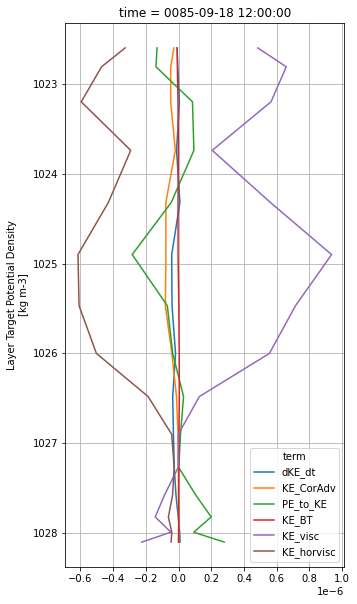

In [21]:
spatial_mean_ke_budget_plot.plot.line(hue='term', y='zl',
                                      figsize=(5, 10), yincrease=False)
plt.grid()